# Dark-Bias Processing Notebook for FITS Images

In [1]:
import os
import re
from pathlib import Path
import numpy as np
from astropy.io import fits
from collections import defaultdict
import matplotlib.pyplot as plt

from tqdm import tqdm

# --- Configurable Variables ---

In [2]:
INPUT_DIR = Path("/home/gabriel/hdd4TB/2025/tests_ricard")  # Change this to your actual input directory
OUTPUT_DIR = Path("/home/gabriel/hdd4TB/2025/photsat_photometric_pipeline/model_dark_test/ricard")
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Helper Functions ---

In [3]:
def parse_filename(filename):
    filename = filename.lower().strip()
    pattern = r'^(dark|bias)_([0-9]+(?:\.[0-9]+)?)sec_g([0-9]{4})_([0-9]{4})\.fits$'
    match = re.match(pattern, filename)
    if match:
        kind, sec, gain, frameid = match.groups()
        return kind, float(sec), int(gain), int(frameid)
    return None

def load_fits(filepath):
    with fits.open(filepath) as hdul:
        data = hdul[0].data.astype(np.float32)
        header = hdul[0].header.copy()
    return data, header

def save_fits(filepath, data, header):
    hdu = fits.PrimaryHDU(data, header=header)
    hdu.writeto(filepath, overwrite=True)

def find_all_fits(input_dir):
    files = list(Path(input_dir).rglob("*.fits"))
    fits_by_config = defaultdict(list)
    for f in tqdm(files, desc="Searching files"):
        info = parse_filename(f.name)
        if info:
            kind, sec, gain, frameid = info
            key = (kind, sec, gain)
            fits_by_config[key].append((f, frameid))
        else:
            print(f"[!] Skipping (no match): {f.name}")  # <-- DEBUG LINE
    return fits_by_config

def make_master_frame(file_list):
    frames = []
    headers = []
    for path, _ in file_list:
        data, header = load_fits(path)
        frames.append(data)
        headers.append(header)
    master = np.mean(frames, axis=0)
    return master, headers

def correlate_and_subtract(darks_by_config, masters):
    subtracted_darks = {}
    for (kind, sec, gain), files in darks_by_config.items():
        if kind != "dark":
            continue
        bias_key = ("bias", 0, gain)
        if bias_key not in masters:
            continue
        master_bias, bias_headers = masters[bias_key]
        dark_stack = []
        output_paths = []
        for path, _ in files:
            data, header = load_fits(path)
            dark_minus_bias = data - master_bias
            output_name = f"darksub_{sec:02}sec_g{gain:04}_{path.stem[-4:]}.fits"
            output_path = OUTPUT_DIR / output_name
            combined_header = header.copy()
            for k, v in bias_headers[0].items():
                if k not in combined_header:
                    combined_header[k] = v
            save_fits(output_path, dark_minus_bias, combined_header)
            dark_stack.append(dark_minus_bias)
            output_paths.append((output_path, sec, gain))
        subtracted_darks[(sec, gain)] = dark_stack, output_paths
    return subtracted_darks

def analyze_dark_current(subtracted_darks):
    for (sec, gain), (stack, output_paths) in subtracted_darks.items():
        if not stack:
            continue
        mean_dark = np.mean(stack, axis=0)
        dark_current = mean_dark / sec  # ADU/sec per pixel
        output_path = OUTPUT_DIR / f"darkcurrentmap_{sec:02}sec_g{gain:04}.fits"
        hdr = fits.Header()
        hdr['EXPTIME'] = sec
        hdr['GAIN'] = gain
        hdr['COMMENT'] = "Dark current map in ADU/s"
        save_fits(output_path, dark_current, hdr)

        # Optional: Diagnostic plot
        plt.figure()
        plt.imshow(dark_current, cmap='inferno')
        plt.colorbar(label='ADU/s')
        plt.title(f"Dark Current Map - {sec}s, Gain {gain}")
        plt.savefig(OUTPUT_DIR / f"darkcurrentmap_{sec:02}sec_g{gain:04}.png")
        plt.close()

# --- Main Execution ---


In [4]:
def main():
    print("Organizing files...")
    fits_by_config = find_all_fits(INPUT_DIR)
    print(len(fits_by_config))
    print("Creating master frames...")
    masters = {}
    for key, file_list in tqdm(fits_by_config.items()):
        master, headers = make_master_frame(file_list)
        masters[key] = (master, headers)
        fname = f"master_{key[0]}_{key[1]:02}sec_g{key[2]:04}.fits"
        save_fits(OUTPUT_DIR / fname, master, headers[0])

    print("Subtracting bias from darks...")
    subtracted_darks = correlate_and_subtract(fits_by_config, masters)

    print("Analyzing dark current...")
    analyze_dark_current(subtracted_darks)

    print("Done.")

In [5]:
for path in INPUT_DIR.rglob("*.fits"):
    print(f"Filename: {path.name}")
    result = parse_filename(path.name)
    print(f" -> Parsed: {result}")

Filename: flat_0.5sec_g0100_0013.fits
 -> Parsed: None
Filename: bias_00sec_g1000_0102.fits
 -> Parsed: ('bias', 0.0, 1000, 102)
Filename: dark_60sec_g0100_0004.fits
 -> Parsed: ('dark', 60.0, 100, 4)
Filename: flat_06sec_g1000_0058.fits
 -> Parsed: None
Filename: flat_08sec_g1000_0055.fits
 -> Parsed: None
Filename: bias_00sec_g0100_0024.fits
 -> Parsed: ('bias', 0.0, 100, 24)
Filename: dark_06sec_g0100_0022.fits
 -> Parsed: ('dark', 6.0, 100, 22)
Filename: flat_0.2sec_g1000_0067.fits
 -> Parsed: None
Filename: flat_10sec_g1000_0053.fits
 -> Parsed: None
Filename: dark_02sec_g0100_0016.fits
 -> Parsed: ('dark', 2.0, 100, 16)
Filename: dark_01sec_g0100_0028.fits
 -> Parsed: ('dark', 1.0, 100, 28)
Filename: bias_00sec_g0100_0045.fits
 -> Parsed: ('bias', 0.0, 100, 45)
Filename: flat_08sec_g1000_0056.fits
 -> Parsed: None
Filename: dark_02sec_g1000_0078.fits
 -> Parsed: ('dark', 2.0, 1000, 78)
Filename: dark_01sec_g0100_0027.fits
 -> Parsed: ('dark', 1.0, 100, 27)
Filename: flat_06sec_g0

In [6]:
main()

Organizing files...


Searching files: 100%|██████████| 164/164 [00:00<00:00, 135326.75it/s]


[!] Skipping (no match): flat_0.5sec_g0100_0013.fits
[!] Skipping (no match): flat_06sec_g1000_0058.fits
[!] Skipping (no match): flat_08sec_g1000_0055.fits
[!] Skipping (no match): flat_0.2sec_g1000_0067.fits
[!] Skipping (no match): flat_10sec_g1000_0053.fits
[!] Skipping (no match): flat_08sec_g1000_0056.fits
[!] Skipping (no match): flat_06sec_g0100_0006.fits
[!] Skipping (no match): flat_04sec_g1000_0059.fits
[!] Skipping (no match): flat_0.5sec_g1000_0065.fits
[!] Skipping (no match): flat_10sec_g1000_0054.fits
[!] Skipping (no match): flat_0.2sec_g0100_0015.fits
[!] Skipping (no match): flat_0.5sec_g1000_0066.fits
[!] Skipping (no match): flat_0.2sec_g1000_0068.fits
[!] Skipping (no match): flat_02sec_g1000_0061.fits
[!] Skipping (no match): flat_08sec_g0100_0003.fits
[!] Skipping (no match): flat_02sec_g1000_0062.fits
[!] Skipping (no match): flat_08sec_g0100_0004.fits
[!] Skipping (no match): flat_06sec_g1000_0057.fits
[!] Skipping (no match): flat_02sec_g0100_0010.fits
[!] Sk

100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Subtracting bias from darks...
Analyzing dark current...
Done.


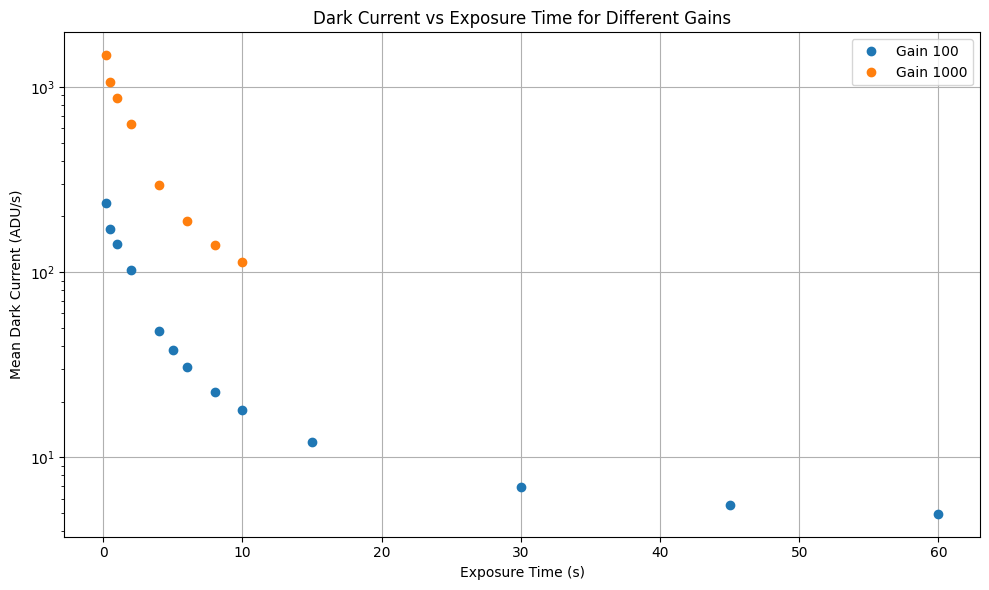

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from astropy.io import fits
import re

output_dir = OUTPUT_DIR

# Regex pattern to identify dark current maps and extract metadata
pattern = r"darkcurrentmap_([0-9]+(?:\.[0-9]+)?)sec_g([0-9]{4})\.fits"

# Initialize list to hold the metadata and mean dark current values
data = []

# Search for all relevant files in output directory
for file in output_dir.glob("darkcurrentmap_*sec_g*.fits"):
    match = re.match(pattern, file.name)
    if match:
        sec, gain = match.groups()
        sec = float(sec)
        gain = int(gain)
        with fits.open(file) as hdul:
            dark_current_map = hdul[0].data
            mean_current = np.mean(dark_current_map)
        data.append((sec, gain, mean_current))

# Convert to numpy array for plotting
data = np.array(data)
exposures = data[:, 0]
gains = data[:, 1] 
mean_currents = data[:, 2] / 16

# Create the plot
plt.figure(figsize=(10, 6))
for gain in np.unique(gains):
    mask = gains == gain
    plt.plot(exposures[mask], mean_currents[mask], marker='o', label=f'Gain {int(gain)}', ls="")

plt.xlabel('Exposure Time (s)')
plt.ylabel('Mean Dark Current (ADU/s)')
plt.title('Dark Current vs Exposure Time for Different Gains')
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()